# 1. Import Ntuple

In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cm
import plotly.express as px
from termcolor import colored
import pandas as pd
import numpy as np
import uproot
from tqdm.auto import tqdm
tqdm.pandas()
import sys
sys.path.append('/home/belle/zhangboy/inclusive_R_D/')
import utilities as util

training_variables = util.training_variables
variables = util.variables

In [2]:
# Generic MC14ri Ntuple locations
files = ['hashed_bbbar_0.root:B0', 
         'hashed_bbbar_2.root:B0',
         'hashed_bbbar_3.root:B0', 
         'hashed_bbbar_4.root:B0',
         'hashed_bbbar_5.root:B0']

lepton_mode = 'e'
columns=['__experiment__','__run__','__event__','__production__','B0_isContinuumEvent',
         'DecayMode', 'p_D_l', 'B_D_ReChi2','B0_mcPDG','B0_mcErrors','D_mcErrors','D_mcPDG',
         'D_M','D_genMotherPDG',f'{lepton_mode}_genMotherPDG', f'{lepton_mode}_mcPDG',
         f'{lepton_mode}_mcErrors',f'{lepton_mode}_pSig']+variables

df_test = uproot.concatenate([f'../Samples/Generic_MC14ri/MC14ri_bbbar_foldex_e_2/{f}' for f in files],
                        library="np",
                        #cut='DecayMode>0',
                        filter_branch=lambda branch: branch.name in columns)
df = pd.DataFrame(df_test)

In [2]:
# Generic MC15ri Ntuple locations
files = ['MC15ri_mixed_1ab_korat_e_1/hashed_mixed_1ab_0.root:B0', 
         'MC15ri_charged_1ab_korat_e_1/hashed_charged_1ab_0.root:B0',]
#          'hashed_bbbar_2.root:B0',
#          'hashed_bbbar_3.root:B0', 
#          'hashed_bbbar_4.root:B0',
#          'hashed_bbbar_5.root:B0']

lepton_mode = 'e'
columns=['__experiment__','__run__','__event__','__production__','B0_isContinuumEvent',
         'DecayMode', 'p_D_l', 'B_D_ReChi2','B0_mcPDG','B0_mcErrors','D_mcErrors','D_mcPDG',
         'D_M','D_genMotherPDG',f'{lepton_mode}_genMotherPDG', f'{lepton_mode}_mcPDG',
         f'{lepton_mode}_mcErrors',f'{lepton_mode}_pSig','B0_mcDaughter_0_PDG',
         'B0_mcDaughter_1_PDG', f'{lepton_mode}_genGMPDG']+variables

df_test = uproot.concatenate([f'../Samples/Generic_MC15ri/{f}' for f in files],
                        library="np",
                        #cut='DecayMode>0',
                        filter_branch=lambda branch: branch.name in columns)
df = pd.DataFrame(df_test)

In [7]:
# Signal MC15ri Ntuple locations
files = [#'MC15ri_sigDDst_korat_e_3/hashed_sigDDst.root:B0', 
         'MC15ri_normDDst_korat_e_1/hashed_normDDst.root:B0',
         'MC15ri_Dststell2_korat_e_3/hashed_Dststell2.root:B0', ]
         #'MC15ri_DststTau1_korat_e_3/hashed_DststTau1.root:B0',
         #'MC15ri_DststTau2_korat_e_3/hashed_DststTau2.root:B0']

lepton_mode = 'e'
columns=['__experiment__','__run__','__event__','__production__','B0_isContinuumEvent',
         'DecayMode', 'p_D_l', 'B_D_ReChi2','B0_mcPDG','B0_mcErrors','D_mcErrors','D_mcPDG',
         'D_M','D_genMotherPDG',f'{lepton_mode}_genMotherPDG', f'{lepton_mode}_mcPDG',
         f'{lepton_mode}_mcErrors',f'{lepton_mode}_pSig','B0_mcDaughter_0_PDG',
         'B0_mcDaughter_1_PDG', f'{lepton_mode}_genGMPDG']+variables

df_test = uproot.concatenate([f'../Samples/Signal_MC15ri/{f}' for f in files],
                        library="np",
                        #cut='DecayMode>0',
                        filter_branch=lambda branch: branch.name in columns)
df = pd.DataFrame(df_test)

In [8]:
# load MVA
import lightgbm as lgb
# load model to predict
bst_lgb = lgb.Booster(model_file=f'../BDTs/LightGBM/lgbm_multiclass.txt')

pred = bst_lgb.predict(df[training_variables], num_iteration=50) #bst_lgb.best_iteration
lgb_out = pd.DataFrame(pred, columns=['signal_prob','continuum_prob','fakeD_prob','fakeB_prob'])

df_lgb = pd.concat([df, lgb_out], axis=1)
df_lgb['largest_prob'] = df_lgb[['signal_prob','continuum_prob','fakeD_prob','fakeB_prob']].max(axis=1)
del pred, df, lgb_out

cut='signal_prob==largest_prob and signal_prob>0.8'

In [4]:
# Test, apply the MVA cut
df_cut=df_lgb.query(cut)
df_bestSelected=df_cut.loc[df_cut.groupby(['__experiment__','__run__','__event__','__production__']).B_D_ReChi2.idxmin()]
df_fakeD=df_bestSelected.query('B0_mcErrors!=512 and B0_isContinuumEvent!=1 and (abs(D_mcPDG)!=411 or D_mcErrors>=8)')

In [34]:
def statistics(df):
    counts=df.count()
    mean=df.mean()
    std=df.std()
    return f'''counts = %d \nmean = %5.3f \nstd = %5.3f''' %(counts,mean,std)

def plot_hist_2d(sample, name, variables=['B0_CMS3_weMissM2','p_D_l'], cut=None):
        variable_x, variable_y = variables
        xedges = np.linspace(-7, 11, 30)
        if variables[1]=='p_D_l':
            yedges = np.linspace(0, 5, 20)
        elif variables[1]=='B_CMS_E':
            yedges = np.linspace(1.4, 5.6, 42)
        
        
        fig = plt.figure(figsize=[8,6])
        sample_size = len(sample.query(cut)) if cut else len(sample)

        ax = fig.add_subplot(1,1,1)
        (counts, xedges, yedges) = np.histogram2d(
                        sample.query(cut)[variable_x] if cut else sample[variable_x], 
                        sample.query(cut)[variable_y] if cut else sample[variable_y],
                        bins=[xedges, yedges])
        counts = counts.T

        mask_arr = np.ones_like(counts)


        X, Y = np.meshgrid(xedges, yedges)
        im=ax.pcolormesh(X, Y, counts, cmap='rainbow', norm=colors.LogNorm(), alpha=mask_arr)
        ax.grid()
        ax.set_xlim(xedges.min(),xedges.max())
        ax.set_ylim(yedges.min(),yedges.max())
        ax.set_title(name,fontsize=14)
        fig.colorbar(im,ax=ax)
        ax.set_title(name,fontsize=14)

        fig.supylabel('$|p_D|\ +\ |p_l|\ \ \ [GeV]$', x=0.03,fontsize=18)
        fig.supxlabel('$M_{miss}^2\ \ \ [GeV^2/c^4]$', y=0.02,fontsize=18)

In [6]:
fakeD_sr = df_fakeD.query('1.855<D_M<1.885')
fakeD_Lsb = df_fakeD.query('D_M<1.855')
fakeD_Rsb = df_fakeD.query('D_M>1.885')

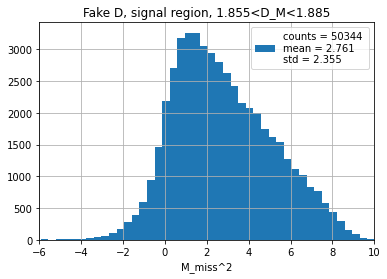

In [9]:
fakeD_sr.hist(column='B0_CMS3_weMissM2',bins=50,label=statistics(fakeD_sr['B0_CMS3_weMissM2']))
plt.title('Fake D, signal region, 1.855<D_M<1.885')
plt.xlim(-6,10)
plt.xlabel('M_miss^2')
plt.legend()

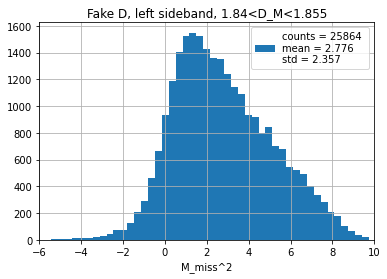

In [11]:
fakeD_Lsb.hist(column='B0_CMS3_weMissM2',bins=50,label=statistics(fakeD_Lsb['B0_CMS3_weMissM2']))
plt.title('Fake D, left sideband, 1.84<D_M<1.855')
plt.xlim(-6,10)
plt.xlabel('M_miss^2')
plt.legend()

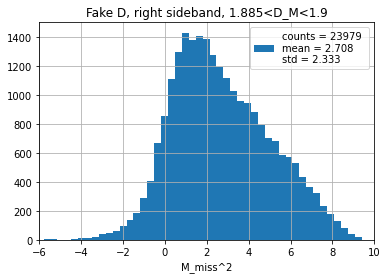

In [12]:
fakeD_Rsb.hist(column='B0_CMS3_weMissM2',bins=50,label=statistics(fakeD_Rsb['B0_CMS3_weMissM2']))
plt.title('Fake D, right sideband, 1.885<D_M<1.9')
plt.xlim(-6,10)
plt.xlabel('M_miss^2')
plt.legend()

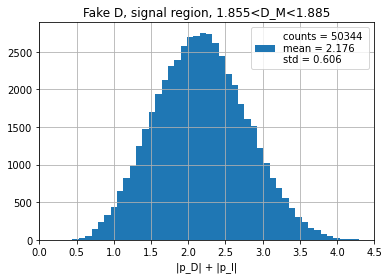

In [13]:
fakeD_sr.hist(column='p_D_l',bins=50,label=statistics(fakeD_sr['p_D_l']))
plt.title('Fake D, signal region, 1.855<D_M<1.885')
plt.xlim(0,4.5)
plt.xlabel('|p_D| + |p_l|')
plt.legend()

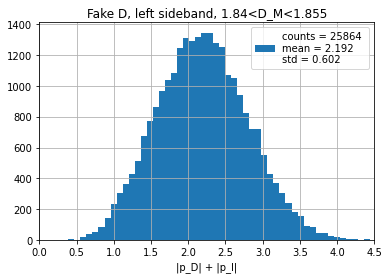

In [16]:
fakeD_Lsb.hist(column='p_D_l',bins=50,label=statistics(fakeD_Lsb['p_D_l']))
plt.title('Fake D, left sideband, 1.84<D_M<1.855')
plt.xlim(0,4.5)
plt.xlabel('|p_D| + |p_l|')
plt.legend()

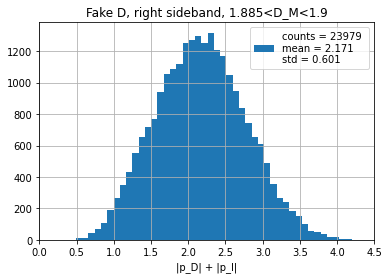

In [17]:
fakeD_Rsb.hist(column='p_D_l',bins=50,label=statistics(fakeD_Rsb['p_D_l']))
plt.title('Fake D, right sideband, 1.885<D_M<1.9')
plt.xlim(0,4.5)
plt.xlabel('|p_D| + |p_l|')
plt.legend()

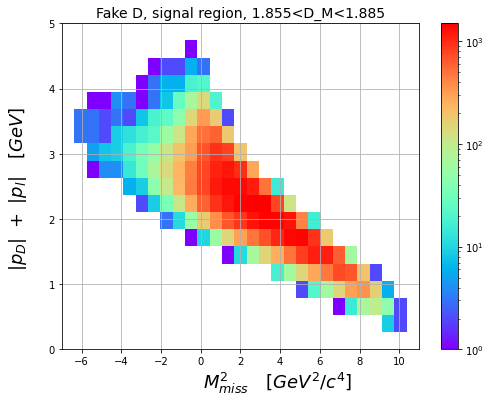

In [35]:
plot_hist_2d(fakeD_sr, name='Fake D, signal region, 1.855<D_M<1.885')

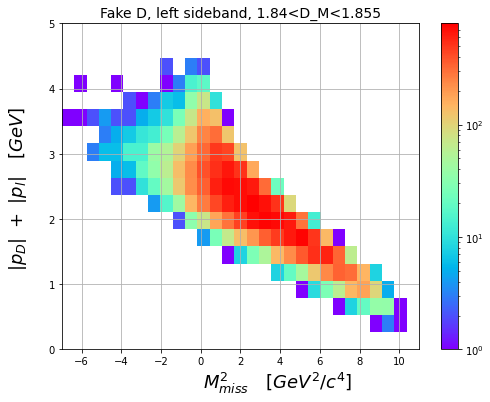

In [36]:
plot_hist_2d(fakeD_Lsb, name='Fake D, left sideband, 1.84<D_M<1.855')

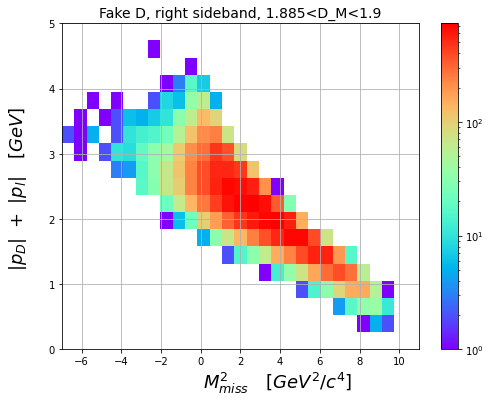

In [37]:
plot_hist_2d(fakeD_Rsb, name='Fake D, right sideband, 1.885<D_M<1.9')

In [9]:
# apply but skip the MVA cut
df_cut=df_lgb#.query(cut)
df_bestSelected=df_cut.loc[df_cut.groupby(['__experiment__','__run__','__event__','__production__']).B_D_ReChi2.idxmin()]
df, samples=util.get_dataframe_samples(df_bestSelected, 'e', template=False, new=True)
mpl=util.mpl(samples)
ply=util.ply(df)
for name, df in samples.items():
    print(name, len(df))

$D\tau\nu$ 187
$D^\ast\tau\nu$ 129
$D^{\ast\ast}\tau\nu$_mixed 54
$D^{\ast\ast}\tau\nu$_charged 68
$D\ell\nu$ 78460
$D^\ast\ell\nu$ 59817
res_$D^{\ast\ast}\ell\nu$_mixed 17308
nonres_$D^{\ast\ast}\ell\nu$_mixed 3973
gap_$D^{\ast\ast}\ell\nu$_mixed 7739
res_$D^{\ast\ast}\ell\nu$_charged 23990
nonres_$D^{\ast\ast}\ell\nu$_charged 4701
bkg_fakeTC 18112
bkg_continuum 0
bkg_fakeD 639932
bkg_combinatorial 38215
bkg_Odecay 3251
bkg_others 0


In [10]:
# Check for duplicate entries
util.check_duplicate_entries(samples)

No duplicate pairs found.


In [11]:
# apply but skip the MVA cut
df_cut=df_lgb#.query(cut)
df_bestSelected=df_cut.loc[df_cut.groupby(['__experiment__','__run__','__event__','__production__']).B_D_ReChi2.idxmin()]
df, samples=util.get_dataframe_samples(df_bestSelected, 'e', template=False, new=False)
mpl=util.mpl(samples)
ply=util.ply(df)
for name, df in samples.items():
    print(name, len(df))

$D\tau\nu$ 187
$D^\ast\tau\nu$ 129
$D^{\ast\ast}\tau\nu$_mixed 54
$D^{\ast\ast}\tau\nu$_charged 68
$D\ell\nu$ 78453
$D^\ast\ell\nu$ 59813
res_$D^{\ast\ast}\ell\nu$_mixed 17319
nonres_$D^{\ast\ast}\ell\nu$_mixed 3971
gap_$D^{\ast\ast}\ell\nu$_mixed 7725
res_$D^{\ast\ast}\ell\nu$_charged 23988
nonres_$D^{\ast\ast}\ell\nu$_charged 4700
bkg_fakeTC 18112
bkg_continuum 0
bkg_fakeD 639932
bkg_combinatorial 38215
bkg_Odecay 3251
bkg_others 19


In [20]:
Dstst_list = [10413, 10411, 20413, 415, 10423, 10421, 20423, 425,
                     -10413, -10411, -20413, -415, -10423, -10421, -20423, -425]
B2Dstst_tau = 'B0_mcDaughter_0_PDG in @Dstst_list and abs(B0_mcDaughter_1_PDG)==15'
true_B0 = 'B0_mcPDG*D_mcPDG==-511*411'
B2D_tau = 'B0_mcDaughter_0_PDG*B0_mcDaughter_1_PDG==411*15'
mode='e'
lepton_PDG = {'e':11, 'mu':13}

# Define Truth matching criteria
true_D_tau = f'D_mcErrors<8 and D_mcPDG*{mode}_mcPDG==411*{lepton_PDG[mode]} and {mode}_genGMPDG==B0_mcPDG and abs({mode}_genMotherPDG)==15'


DecayErrors = {}
# norm modes, signal modes, D** mixed modes
for key, value in {'D_l':[8,16],'Dst_l':[8,64],'D_tau':[8,32],'Dst_Dstst_mixed':[8,64]}.items():
                # tau to e has a 1% radiative mode, thus 32
    correct_decay = f'({value[0]}+{mode}_mcErrors)<=B0_mcErrors<({value[1]}+{mode}_mcErrors)'
    missing_photon = f'({value[0]+1024}+{mode}_mcErrors)<=B0_mcErrors<({value[1]+1024}+{mode}_mcErrors)'

#         wrongBremsDaughter = f'{value[0]+2048}<=B0_mcErrors<{value[1]+2048+128}'
#         missing_photon_wrongBrems = f'{value[0]+2048+1024}<=B0_mcErrors<{value[1]+2048+1024+128}'

    DecayErrors[f'{key}_errors'] = f'({correct_decay} or {missing_photon})'
    # note that the parentheses in the `or` statement is very important when using `and` in front


# D** charged modes
Bcharged_errors = f'({8+256}+{mode}_mcErrors)<=B0_mcErrors<({64+256}+{mode}_mcErrors)'
missing_photon_Bcharged = f'({8+1024+256}+{mode}_mcErrors)<=B0_mcErrors<({64+1024+256}+{mode}_mcErrors)'

# a charged particle (e.g. pi,e,mu) is added as a Brems daughter by the correctBrem module
# however, this mistake doesn't change the MM2 and p_D_l much, still within the signal window
# B0_mcErrors is offset by 128 due to the misID of the Brems daughter
#     wrongBremsDaughter_Bcharged = f'{8+2048+256}<=B0_mcErrors<{64+2048+256+128}'
#     missing_photon_wrongBrems_Bcharged = f'{8+2048+1024+256}<=B0_mcErrors<{64+2048+1024+256+128}'

DecayErrors[f'Bcharged_errors'] = f'({Bcharged_errors} or {missing_photon_Bcharged})'
#         if template:
#             DecayErrors[f'Bcharged_errors'] = Bcharged_errors

In [33]:
df_test8 = samples[r'$D\ell\nu$']
df_test8[['B0_B0Mode','B0_Bbar0Mode','B0_mcErrors','B0_mcPDG','D_mcErrors','D_mcPDG','D_genMotherPDG','e_genMotherPDG',
          'e_mcErrors','e_mcPDG','B0_mcDaughter_0_PDG','B0_mcDaughter_1_PDG',]]

,B0_B0Mode,B0_Bbar0Mode,B0_mcErrors,B0_mcPDG,D_mcErrors,D_mcPDG,D_genMotherPDG,e_genMotherPDG,e_mcErrors,e_mcPDG,B0_mcDaughter_0_PDG,B0_mcDaughter_1_PDG
412,301002.0,-1023.0,1032.0,511.0,0.0,-411.0,511.0,511.0,0.0,-11.0,-411.0,-11.0
1016,1023.0,1002.0,8.0,511.0,0.0,-411.0,511.0,511.0,0.0,-11.0,-411.0,-11.0
1101,-101002.0,-1036.0,1032.0,-511.0,0.0,411.0,-511.0,-511.0,0.0,11.0,411.0,11.0
1109,1003.0,101002.0,1032.0,511.0,0.0,-411.0,511.0,511.0,0.0,-11.0,-411.0,-11.0
1263,1023.0,-1002.0,8.0,-511.0,0.0,411.0,-511.0,-511.0,0.0,11.0,411.0,11.0
1751,1021.0,-101002.0,1032.0,-511.0,0.0,411.0,-511.0,-511.0,0.0,11.0,411.0,11.0


In [34]:
df_test8.index

Int64Index([412, 1016, 1101, 1109, 1263, 1751], dtype='int64')

In [14]:
# apply but skip the MVA cut
df_cut=df_lgb#.query(cut)
df_bestSelected=df_cut.loc[df_cut.groupby(['__experiment__','__run__','__event__','__production__']).B_D_ReChi2.idxmin()]
df, samples=util.get_dataframe_samples(df_bestSelected, 'e', template=False, new=True)
mpl=util.mpl(samples)
ply=util.ply(df)
for name, df in samples.items():
    print(name, len(df))

$D\tau\nu$ 187
$D^\ast\tau\nu$ 129
$D^{\ast\ast}\tau\nu$_mixed 54
$D^{\ast\ast}\tau\nu$_charged 68
$D\ell\nu$ 78460
$D^\ast\ell\nu$ 59817
res_$D^{\ast\ast}\ell\nu$_mixed 17308
nonres_$D^{\ast\ast}\ell\nu$_mixed 3973
gap_$D^{\ast\ast}\ell\nu$_mixed 7739
res_$D^{\ast\ast}\ell\nu$_charged 23990
nonres_$D^{\ast\ast}\ell\nu$_charged 4701
bkg_fakeTC 18112
bkg_continuum 0
bkg_fakeD 639932
bkg_combinatorial 38215
bkg_Odecay 3251
bkg_others 0


In [15]:
# Check for duplicate entries
util.check_duplicate_entries(samples)

No duplicate pairs found.


In [ ]:
test_p = [0,0.02,0.04,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.75,0.8,0.85,0.9,0.95,0.97,0.98]
mpl.plot_FOM(sigModes=[r'$D\tau\nu$'], bkgModes=['bkg_fakeDTC','bkg_fakeB','bkg_continuum'], variable='signal_prob', test_points=test_p, cut=None)

In [ ]:
mpl.plot_norms_overlaid(variable='e_pSig',cut='B0_CMS3_weMissM2>2.5 and p_D_l<3')

In [ ]:
mpl.plot_norms_overlaid(variable='e_pSig',cut='B0_CMS3_weMissM2>2.5 and p_D_l<3 and e_pSig<100')

In [ ]:
for name, df in samples.items():
    print(name, len(df.query('nElectrons90+nMuons90==1'))/(len(df)+1))

In [ ]:
for name, df in samples.items():
    print(name, len(df.query('nElectrons90+nMuons90==1 and ROEeidBDT<0.5 and ROEmuidBDT<0.5'))/(len(df)+1))

# 2. Plot

In [ ]:
samples[r'$D\ell\nu$'].eval('e_pSig = (e_mcP - e_p)/e_pErr', inplace=True)
samples[r'$D\ell\nu$'].hist('e_pSig',bins=25, by='e_isBremsCorrected')

In [ ]:
mpl.plot_norms_overlaid(variable='e_pSig',cut='B0_CMS3_weMissM2>2.5 and p_D_l<3')

In [ ]:
mpl.plot_hist_2d(cut='signal_prob==largest_prob and signal_prob>0.8', mask=[1.6,1,0.1])

In [ ]:
mpl.plot_hist_2d(cut='signal_prob==largest_prob and signal_prob>0.8', mask=None)

In [ ]:
mpl.plot_hist_2d(cut='signal_prob==largest_prob and signal_prob>0.8', variables=['B0_CMS3_weMissM2','B_CMS_E'],mask=None)

(1.84, 1.9)

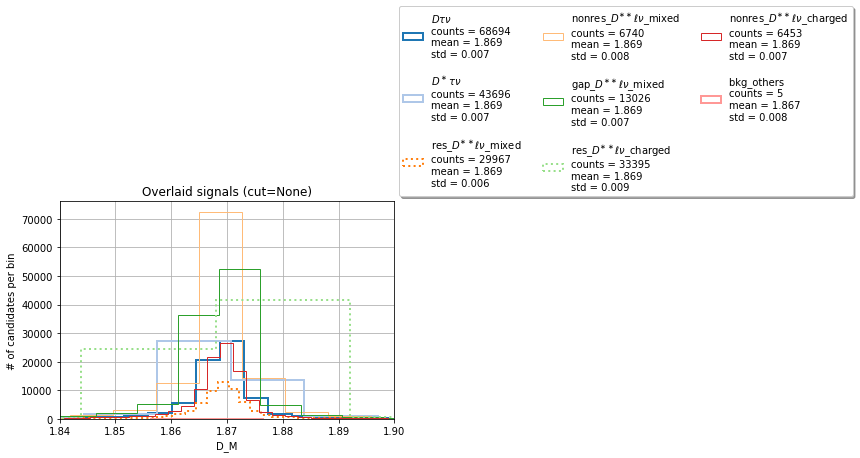

In [26]:
mpl.plot_all_overlaid(variable='D_M',cut=None,
                      mask=['bkg_fakeD','bkg_Odecay','bkg_combinatorial','bkg_fakeTC',
                             r'$D\ell\nu$',r'$D^\ast\ell\nu$',
                            r'$D^{\ast\ast}\tau\nu$_mixed',
                            r'$D^{\ast\ast}\tau\nu$_charged',])
plt.xlim(1.84,1.9)

(1.84, 1.9)

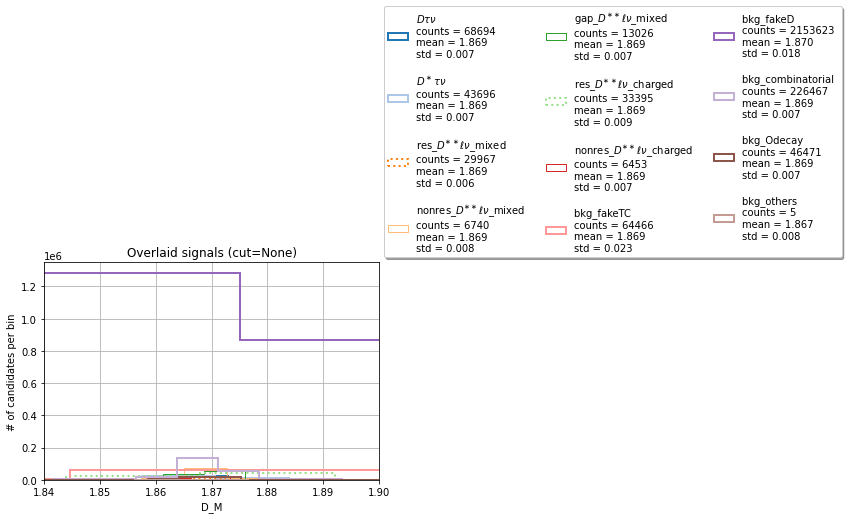

In [28]:
mpl.plot_all_overlaid(variable='D_M',cut=None,
                      mask=[r'$D\ell\nu$',r'$D^\ast\ell\nu$',
                            r'$D^{\ast\ast}\tau\nu$_mixed',
                            r'$D^{\ast\ast}\tau\nu$_charged',])
plt.xlim(1.84,1.9)

In [ ]:
mpl.plot_all_overlaid(variable='p_D_l',cut=None,
                      mask=['bkg_fakeD','bkg_Odecay','bkg_combinatorial','bkg_fakeTC',
                             r'$D\ell\nu$',r'$D^\ast\ell\nu$',
                            r'$D^{\ast\ast}\tau\nu$_mixed',
                            r'$D^{\ast\ast}\tau\nu$_charged',])
plt.xlabel('$|p^{CMS}_D| + |p^{CMS}_\ell| \ \ [GeV/c]$')
plt.title('Overlaid signal MC (different components are scaled)');

In [ ]:
mpl.plot_all_overlaid(variable='e_CMS_p',cut=None,
                      mask=['bkg_fakeD','bkg_Odecay','bkg_combinatorial','bkg_fakeTC',
                             r'$D\ell\nu$',r'$D^\ast\ell\nu$',
                            r'$D^{\ast\ast}\tau\nu$_mixed',
                            r'$D^{\ast\ast}\tau\nu$_charged',])
plt.xlabel('$|p^{CMS}_\ell| \ \ [GeV/c]$')
plt.title('Overlaid signal MC (different components are scaled)');

In [ ]:
mpl.plot_all_overlaid(variable='B0_CMS3_weMissM2',cut=None,
                      mask=['bkg_fakeD','bkg_Odecay','bkg_combinatorial','bkg_fakeTC',
                             r'$D\ell\nu$',r'$D^\ast\ell\nu$',
                            r'$D^{\ast\ast}\tau\nu$_mixed',
                            r'$D^{\ast\ast}\tau\nu$_charged',])
plt.xlabel('$M^2_{miss} \ \ [GeV^2/c^4]$')
plt.title('Overlaid signal MC (different components are scaled)');

In [ ]:
mpl.plot_signals_overlaid(variable='p_D_l',cut='B0_CMS3_weMissM2<2.5',
                      mask=['bkg_fakeD','bkg_Odecay','bkg_combinatorial','bkg_fakeTC',
                             r'$D\ell\nu$',r'$D^\ast\ell\nu$',
                            r'$D^{\ast\ast}\tau\nu$_mixed',
                            r'$D^{\ast\ast}\tau\nu$_charged',])

In [ ]:
mpl.plot_signals_overlaid(variable='e_CMS_p',cut='B0_CMS3_weMissM2<2.5',
                      mask=['bkg_fakeD','bkg_Odecay','bkg_combinatorial','bkg_fakeTC',
                             r'$D\ell\nu$',r'$D^\ast\ell\nu$',
                            r'$D^{\ast\ast}\tau\nu$_mixed',
                            r'$D^{\ast\ast}\tau\nu$_charged',])

In [ ]:
mpl.plot_signals_overlaid(variable='B0_CMS3_weMissM2',cut='p_D_l<2.5',
                      mask=['bkg_fakeD','bkg_Odecay','bkg_combinatorial','bkg_fakeTC',
                             r'$D\ell\nu$',r'$D^\ast\ell\nu$',
                            r'$D^{\ast\ast}\tau\nu$_mixed',
                            r'$D^{\ast\ast}\tau\nu$_charged',])

In [ ]:
mpl.plot_cut_efficiency(cut='signal_prob==largest_prob and signal_prob>0.8', variable='B0_CMS3_weQ2lnuSimple')

In [ ]:
mpl.plot_all_separately(variable='B0_CMS3_weQ2lnuSimple',xlim=[-2,13])